# StructureBoost Workshop - ODSC Europe 2022

## Setup and Preliminaries
### Notebook is in the following repo: www.github.com/numeristical/resources
- #### Clone or download the repo
- #### Navigate to folder "ODSC_Europe_2022"
- #### Find notebook file "StructureBoost_EU_2022_Main.ipynb"
- #### Check Q&A channel for any updates to instructions.

### Suggestion: make a copy of Notebook, go to Kernel->Restart and Clear All Outputs
(This way you can make changes and still refer to the original)

# About Me
## Brian Lucena
- ### Consultant, Researcher, Educator: www.numeristical.com
- ### Work with many startups, as well as larger (public) companies
- ### Youtube channel on Statistical Machine Learning: https://www.youtube.com/numeristical
- ### Frequent Presenter at ODSC, PyData, MLConf  
- ### StructureBoost package: Gradient Boosting with Categorical Structure: www.github.com/numeristical/structureboost
- ### ML-Insights package: Model Interpretability, Probability Calibration (SplineCalib) www.github.com/numeristical/introspective
- ### Research Papers:
    - "Loss Functions for Classification Using Structured Entropy"
    - "Exploiting Categorical Structure using Tree-based Methods" (AISTATS 2020) http://proceedings.mlr.press/v108/lucena20a/lucena20a.pdf
    - "StructureBoost: Efficient Gradient Boosting for Structured Categorical Variables" https://arxiv.org/abs/2007.04446
    - "Spline-Based Probability Calibration" https://arxiv.org/abs/1809.07751
  

___________________
#### This notebook gives a tutorial on StructureBoost - a gradient boosting package that can exploit the **structure** of categorical variables.

A useful 15-min primer on Categorical Structure and StructureBoost can be viewed here:
https://youtu.be/u0Wlofm60rA

As of May 2022, StructureBoost has been enhanced to additionally exploit structure in the target variable (for multi-class classification)

By the end of this notebook, you should:
- Understand the notion of a "Structured" Categorical Variable
- Know some basics on how to configure StructureBoost to use structured categorical variables, both as predictors and as the target.

This notebook assumes:
- Experience in using python to fit models and make predictions
- Some familiarity with Gradient Boosting, Decision Trees, etc.


------------
For more details on Categorical Structure and StructureBoost, you can read the following papers:

Lucena, B. "Loss Functions for Classification Using Structured Entropy"

Lucena, B. "Exploiting Categorical Structure with Tree-Based Methods. Proceedings of the Twenty Third International Conference
on Artificial Intelligence and Statistics, PMLR 108:2949-2958, 2020. http://proceedings.mlr.press/v108/lucena20a/lucena20a.pdf

Lucena, B. "StructureBoost: Efficient Gradient Boosting for Structured
Categorical Variables." https://arxiv.org/abs/2007.04446

Or also read the StructureBoost documentation at:
https://structureboost.readthedocs.io/

----------------

## Options to use this notebook:
- (Recommended) Clone the repo at https://github.com/numeristical/resources and use your own environment (be sure to `pip install structureboost`)
- Use Google colab: https://colab.research.google.com (free: Google account required) and get the notebook and data from github


## Motivating Problem: Predicting Rainfall in California Counties by Month

Our first practical problem will involve predicting the probability of rainfall given a particular month and county in California.  This is an interesting problem for several reasons:

1. Both the county and month are categorical variables, which do not lend themselves well to traditional approaches.
1. We can use actual data from NOAA
1. We have enough data to essentially "know" the correct answer
1. Still we can limit ourselves to smaller (training) data sets to see how well we can do.

--------------------------------------

## Problem Introduction

There are 58 counties in California as shown by the map below:

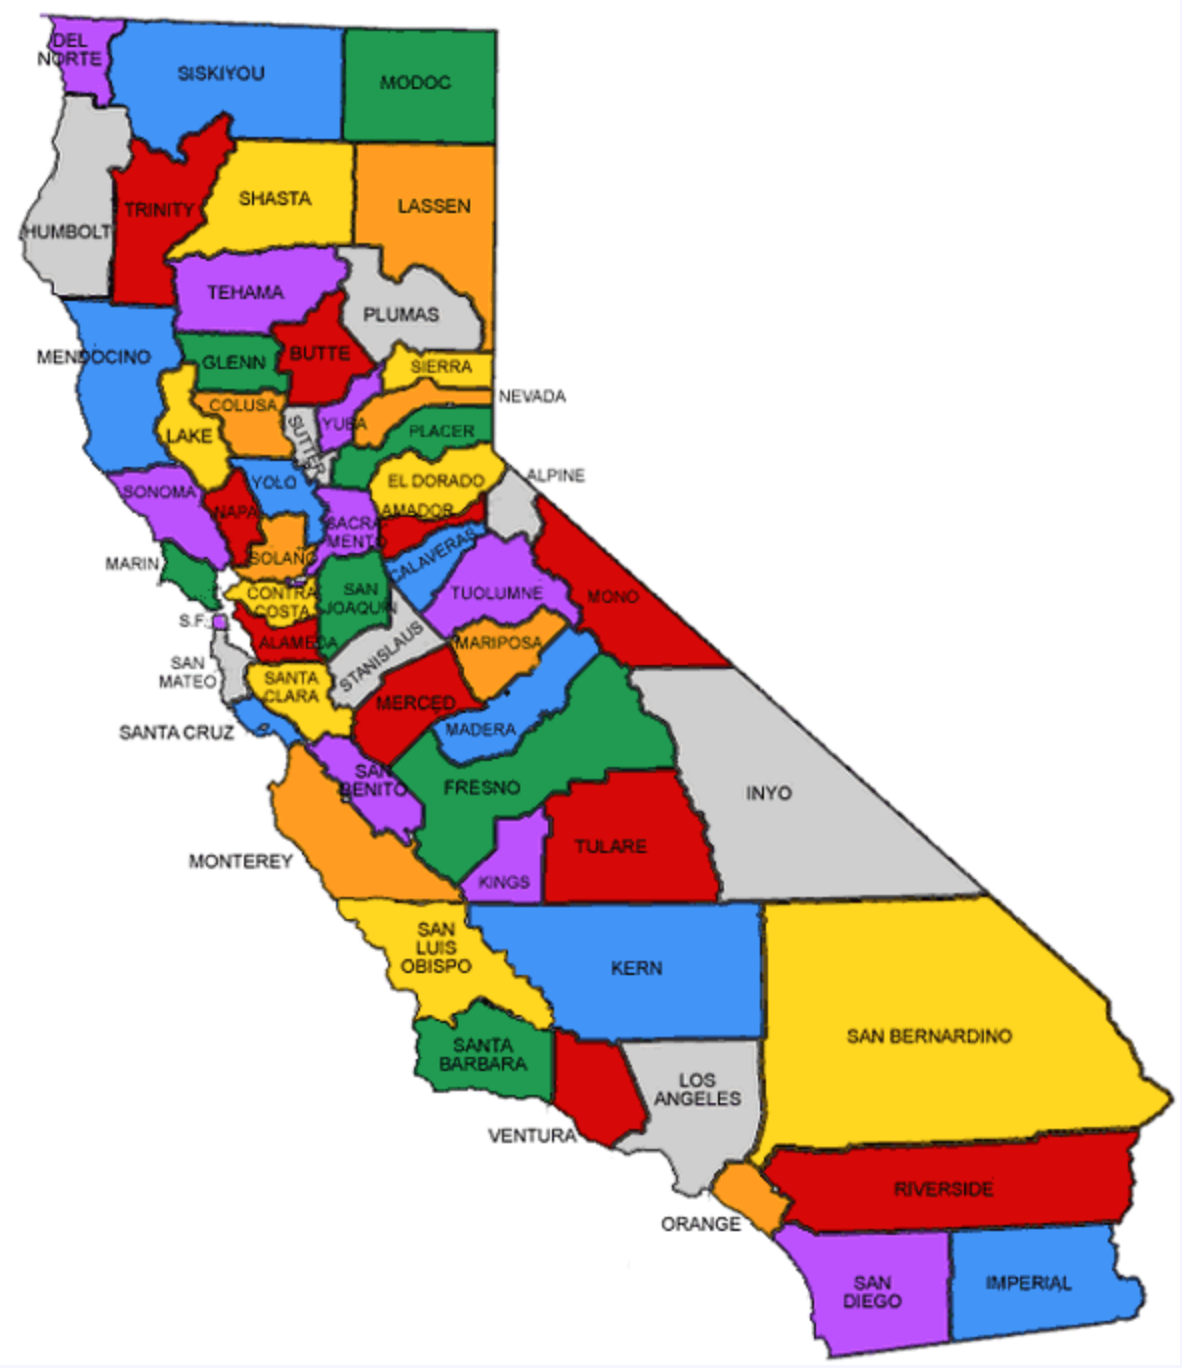

California has a lot of geographical variety: Coastal, Mountain, Desert.  Clearly, different counties will have different rainfall patterns over the months of the year.

Our goal is to predict the probability of rainfall for a day given just two attributes:
1. Which **county** the observation is from
2. Which **month** the observation is from

For example, what is the probability of rain in April in Riverside county?

There are 58 counties and 12 months, for a total of 12 * 58 = 696 different month/county combinations.  So, our "model" is essentially a collection of 696 probability estimates. 

We will judge the quality of our model by calculating the **log_loss** on an independent test set.  Log_loss is also known as **cross-entropy** and is equivalent to using the **maximum-likelihood** principle.  (Log_loss is the negative log likelihood divided by the size of the test set).

## Imports

In [1]:
# If structureboost not already installed, or on google colab
# !pip install structureboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
import copy

import structureboost as stb

pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)

stb.__version__

'0.2.1'

## Load and Process Data

In [3]:
# If you cloned the repo
df_ca_PRCP = pd.read_csv('../data/CA_County_PRCP.csv')

# If using Google colab try
# df_ca_PRCP = pd.read_csv('https://raw.githubusercontent.com/numeristical/resources/master/data/CA_County_PRCP.csv')

df_ca_PRCP.sample(5)

,county,month,DATE,STATION,PRCP,rained,county_DATE
373419,Trinity,2,2001-02-11,USC00040738,0.19,1,Trinity___2001-02-11
400952,Ventura,6,2017-06-15,USC00046399,0.00,0,Ventura___2017-06-15
77340,Humboldt,8,2000-08-11,USW00024283,0.00,0,Humboldt___2000-08-11
287557,San_Mateo,12,2012-12-12,US1CASM0006,0.10,1,San_Mateo___2012-12-12
32895,Calaveras,9,2012-09-17,USC00041428,0.00,0,Calaveras___2012-09-17


In [4]:
df_ca_PRCP.shape

(415930, 7)

## Data Exploration

The first thing to note, is that we actually have a LOT of data for this problem:
- We are estimating 696 (binomial) probabilities, and have ~600 data points for each county/month combo.
- The events are (mostly) not that rare.
- So, using all of our data, we effectively "know" the right answer to a few percentage points.
- e.g. the standard deviation of the binomial if p=.1 is sqrt(.1 * .9 / 600) = .012

In [5]:
# To get the estimates of the "right" answer using all our data, we can do a simple groupby
mean_by_mc_full = df_ca_PRCP.groupby(['month','county'])['rained'].agg(['mean','count']).reset_index()
mean_by_mc_full.columns = ['month', 'county', 'prob_of_rain', 'num_obs']
mean_by_mc_full.sample(5)

,month,county,prob_of_rain,num_obs
181,4,Del_Norte,0.501667,600
633,11,Tulare,0.168333,600
150,3,San_Benito,0.250000,620
575,10,Tulare,0.100000,620
70,2,Imperial,0.076106,565


Let's first understand the nature of our data before giving details of our modeling problem.

In [6]:
## Let's write a simple function to display the seasonal rain pattern of a given county
def plot_county_rainfalls(target_counties, rain_df):
    for cnty in target_counties:
        small_mean_df = rain_df[rain_df.county==cnty]
        plt.plot(small_mean_df.month, small_mean_df.prob_of_rain, '-o', label=cnty)
        plt.ylim([0,.8])
        plt.xlabel('Month')
        plt.ylabel('Prob of Rainfall')
    plt.legend()  

#### As you can see, there are a variety of seasonal rainfall patterns in the different counties in California

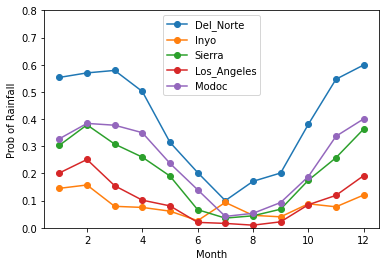

In [7]:
target_counties = ['Del_Norte', 'Inyo', 'Sierra', 'Los_Angeles', 'Modoc']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### But counties in the same regions display similar behavior
### Here are some counties in the Northwest of the state - this is a rainy region

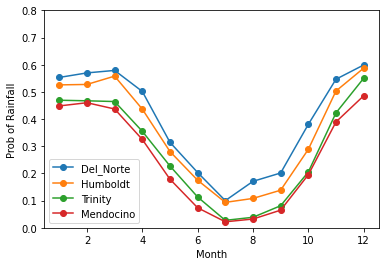

In [8]:
target_counties = ['Del_Norte', 'Humboldt', 'Trinity', 'Mendocino']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### Here are counties in the southeast - more of a desert climate

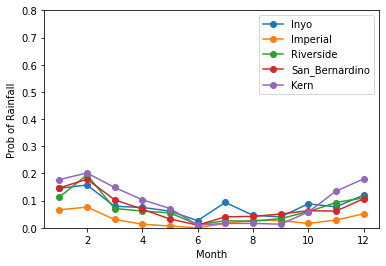

In [9]:
target_counties = ['Inyo', 'Imperial', 'Riverside', 'San_Bernardino', 'Kern']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### In the mountains near the Nevada border

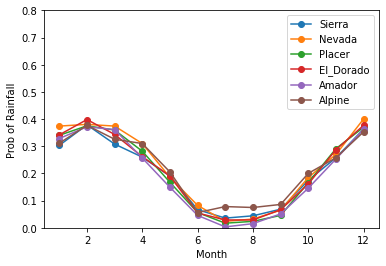

In [10]:
target_counties = ['Sierra', 'Nevada', 'Placer', 'El_Dorado', 'Amador', 'Alpine']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### Southern Coastal counties

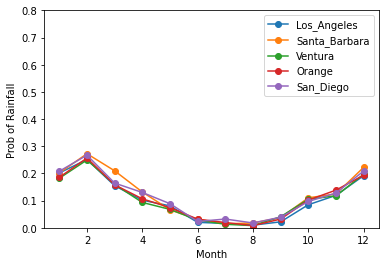

In [11]:
target_counties = ['Los_Angeles', 'Santa_Barbara', 'Ventura', 'Orange', 'San_Diego']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### Northeastern counties

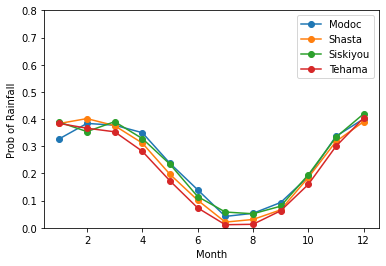

In [12]:
target_counties = ['Modoc', 'Shasta', 'Siskiyou','Tehama']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### Though, in some cases, neighboring counties may have quite different patterns

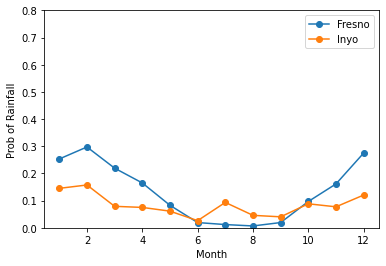

In [13]:
target_counties = ['Fresno', 'Inyo']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### Our Challenge
**Key Observation: With enough data, you don't need really need a model**

We could just compute 696 different means, and if we had enough data on each month/county combination, we would have fairly accurate estimates.

However, what if you only had 1,000 training data points in total?  On average, you would only have 1 or 2 data points per month/county combination.  Taking the mean would give you a terrible estimate.  This is an example of a bias-variance tradeoff.  Broadly speaking, we need to make some assumptions (add bias) to reduce the variance of our estimates.

Speaking more specifically, if I have 500 observations of rain/no rain from Riverside County in April, I can get a good estimate without knowing what other counties are near Riverside, or what other months are "near" April.  But if I have one observation, I will need to know (and exploit) the structure of the counties / months to get a good estimate.


## Brainstorm
How would you attack this problem?

Common approaches:
- Use one-hot encoding (dummy variables) to represent the county.
- Numerical encoding: represent each county by its average rainfall
- Use CatBoost or LightGBM and let the algorithm figure it out

New approach:
- Define the structure of your variables and use StructureBoost

## Set up train, validation, and test sets

In [14]:
## We'll use just two features, county and month
## Target is whether or not it rained
X = df_ca_PRCP.loc[:,['county','month']]
y = df_ca_PRCP.rained.values

In [15]:
X_trva, X_test, y_trva, y_test = train_test_split(X,y, test_size = 100000, random_state=1)
X_train_big, X_valid, y_train_big, y_valid = train_test_split(X_trva, y_trva, test_size = 10000, random_state=1)

In [16]:
num_train_pts = 1000
X_train = X_train_big.iloc[:num_train_pts,:]
y_train = y_train_big[:num_train_pts]

In [17]:
X_train.shape, X_valid.shape, X_test.shape

((1000, 2), (10000, 2), (100000, 2))

## Using StructureBoost For Categorical Predictors
StructureBoost has a more complicated configuration than most other boosting packages.  We won't go through all the details now, but here are some important aspects:
- Many configuration options are available at the *feature* level.
- Configuration relies heavily on `feature_configs` - which is passed as a python dictionary
- The keys of the dictionary will be the feature names - when fitting, will look for those names in your `X_train` dataframe.  So StructureBoost relies on Pandas column names.
- StructureBoost does **not** define the features by the existence of columns in `X_train` or using any *order* of columns
- Creating the dictionary can be tedious, but there are tools to make it simpler.
- StructureBoost uses the same object for classification and regression (set `mode='regression'`, default is classification)
- For Predictors, StructureBoost can use string-valued variables directly, (`categorical_str`), but is faster when category is encoded as an integer (especially at predict time)

### Example feature configuration


In [18]:
# This function looks at your training data, and makes some reasonable guesses as to how to configure
# The result can be used as a "starting point" which can be configured further
feature_configs_default = stb.get_basic_config(X_train, stb.default_config_dict())
feature_configs_default

{'county': {'feature_type': 'categorical_str',
  'graph': <structureboost.graphs.graph_undirected at 0x1415681f0>,
  'split_method': 'span_tree',
  'num_span_trees': 1},
 'month': {'feature_type': 'numerical', 'max_splits_to_search': 25}}

- Note that we have two "keys": `'county'` and `'month'`.
- The corresponding values are dictionaries containing feature-specific configurations


### Defining structure with a graph
- The configuration for a categorical variable must contain a "graph" defining the structure.
- A "graph" here means vertices (dots) and edges (lines connecting pairs of dots).
- When using the `get_basic_config` tool, it will make a "complete" graph. (Every vertex is connected to every other)

In [19]:
## We use a large number of trees, and a low_learning rate.  We will rely on early stopping to choose the "right" number of trees
stboost_CA_def = stb.StructureBoost(num_trees = 2000,
                                    learning_rate=.02,
                                    feature_configs=feature_configs_default, 
                                    max_depth=2,
                                    mode='classification')

In [20]:
# We use the `eval_set`, `early_stop_past_steps` and `eval_freq` to define early stopping
stboost_CA_def.fit(X_train, y_train, 
                   eval_set = ((X_valid, y_valid)), 
                   early_stop_past_steps=1, 
                   eval_freq=20)

i=0, eval_set_loss = 0.47018127601084786
i=20, eval_set_loss = 0.4484983402751395
i=40, eval_set_loss = 0.4358116661651059
i=60, eval_set_loss = 0.430448213275125
i=80, eval_set_loss = 0.42789323838437293
i=100, eval_set_loss = 0.4260362545691486
i=120, eval_set_loss = 0.4243433553894439
i=140, eval_set_loss = 0.4231283007944137
i=160, eval_set_loss = 0.4218907426500843
i=180, eval_set_loss = 0.42162773205432225
i=200, eval_set_loss = 0.4215879902608899
i=220, eval_set_loss = 0.4215787777913419
i=240, eval_set_loss = 0.4215069696421347
i=260, eval_set_loss = 0.4217709258722244
Stopping early: curr_loss of 0.4217709258722244
                                        exceeds compare_loss of 0.4215069696421347


In [21]:
# Unlike other packages `predict` gives probabilities, not "hard" predictions
# For binary classification, `predict` will give the probability that y=1
pred_probs = stboost_CA_def.predict(X_test)

In [22]:
# You can also use `predict_proba` if you like and get the behavior like other packages
pred_probs_proba = stboost_CA_def.predict_proba(X_test)
np.allclose(pred_probs, pred_probs_proba[:,1])

True

In [23]:
# We measure our performance using log_loss
stb_default_loss = log_loss(y_test, pred_probs)
stb_default_loss

0.4240565886263596

## Incorporate structure of "County" feature
Right now, the county feature is using a *complete* graph, where every vertex is adjacent to every other vertex.  This represents the situation where there is essentially no structure in the different values.


In [24]:
# We can build any graph by specifying a set of vertices and edges
my_vertices = ['a','b','c','d']
my_edges = [ ['a','b'],
              ['a','c'],
               ['c','d'],
               ['b','d']]
my_graph = stb.graphs.graph_undirected(edges=my_edges, vertices=my_vertices)
my_graph.vertices, my_graph.edges

({'a', 'b', 'c', 'd'},
 {frozenset({'a', 'c'}),
  frozenset({'c', 'd'}),
  frozenset({'a', 'b'}),
  frozenset({'b', 'd'})})

Let's make a new config that uses the actual CA County adjacency graph. This graph is included in the package, so we don't have to build it from scratch

In [25]:
county_graph = stb.graphs.CA_county_graph()
len(county_graph.vertices), len(county_graph.edges)

(58, 133)

In [26]:
# This graph only has edges between adjacent counties
county_graph.edges

{frozenset({'Sutter', 'Yuba'}),
 frozenset({'Amador', 'San_Joaquin'}),
 frozenset({'Napa', 'Solano'}),
 frozenset({'Glenn', 'Tehama'}),
 frozenset({'Merced', 'Tuolumne'}),
 frozenset({'Los_Angeles', 'San_Bernardino'}),
 frozenset({'Mendocino', 'Trinity'}),
 frozenset({'Merced', 'Stanislaus'}),
 frozenset({'Solano', 'Yolo'}),
 frozenset({'Fresno', 'San_Benito'}),
 frozenset({'Alpine', 'Calaveras'}),
 frozenset({'Santa_Clara', 'Stanislaus'}),
 frozenset({'Santa_Barbara', 'Ventura'}),
 frozenset({'Kern', 'Kings'}),
 frozenset({'Madera', 'Mariposa'}),
 frozenset({'Kern', 'San_Bernardino'}),
 frozenset({'Lake', 'Yolo'}),
 frozenset({'Stanislaus', 'Tuolumne'}),
 frozenset({'Alpine', 'Mono'}),
 frozenset({'Sacramento', 'San_Joaquin'}),
 frozenset({'Alameda', 'Contra_Costa'}),
 frozenset({'Imperial', 'Riverside'}),
 frozenset({'Kern', 'Tulare'}),
 frozenset({'Merced', 'Santa_Clara'}),
 frozenset({'Amador', 'Sacramento'}),
 frozenset({'Alpine', 'Amador'}),
 frozenset({'Modoc', 'Shasta'}),
 froz

In [27]:
# Copy the default configuration, and replace 
# the complete graph (created by the 'get_default_config')
# with the actual CA county graph
feature_configs_1 = copy.deepcopy(feature_configs_default)
feature_configs_1['county']['graph'] = county_graph

In [28]:
feature_configs_1

{'county': {'feature_type': 'categorical_str',
  'graph': <structureboost.graphs.graph_undirected at 0x141568eb0>,
  'split_method': 'span_tree',
  'num_span_trees': 1},
 'month': {'feature_type': 'numerical', 'max_splits_to_search': 25}}

In [29]:
len(feature_configs_1['county']['graph'].edges), len(feature_configs_default['county']['graph'].edges)

(133, 1653)

### Run the model

In [30]:
## We use a large number of trees, and a low_learning rate.  We will rely on early stopping to choose the "right" number of trees
stboost_CA_1 = stb.StructureBoost(num_trees = 2000,
                                  learning_rate=.02,
                                  feature_configs=feature_configs_1, 
                                  max_depth=2,
                                  mode='classification')

In [31]:
# We use the `eval_set`, `early_stop_past_steps` and `eval_freq` to define early stopping
stboost_CA_1.fit(X_train, y_train, 
                   eval_set = ((X_valid, y_valid)), 
                   early_stop_past_steps=1, 
                   eval_freq=20)

i=0, eval_set_loss = 0.47018127601084786
i=20, eval_set_loss = 0.446776806225601
i=40, eval_set_loss = 0.43445653307645427
i=60, eval_set_loss = 0.4273057553104716
i=80, eval_set_loss = 0.423431203646072
i=100, eval_set_loss = 0.4199845038588195
i=120, eval_set_loss = 0.4197219616767843
i=140, eval_set_loss = 0.4183861846400229
i=160, eval_set_loss = 0.41682676311895267
i=180, eval_set_loss = 0.4160158888832708
i=200, eval_set_loss = 0.41646691210121733
Stopping early: curr_loss of 0.41646691210121733
                                        exceeds compare_loss of 0.4160158888832708


In [32]:
# Unlike other packages `predict` gives probabilities, not "hard" predictions
# For binary classification, `predict` will give the probability that y=1
pred_probs_1 = stboost_CA_1.predict(X_test)

In [33]:
# You can also use `predict_proba` if you like and get the behavior like other packages
stb_1_loss = log_loss(y_test, pred_probs_1)
stb_1_auc = roc_auc_score(y_test, pred_probs_1)
stb_1_loss, stb_1_auc

(0.41738341519673516, 0.7427798277379101)

### Incorporating structure in the 'month' feature
Previously we treated the month as a numerical variable.  However, doing so ignores
the fact that December is "adjacent" to January in the same way that "July" is
adjacent to "August".  To more accurately model the structure, we will represent the months
by a "cycle" graph

In [34]:
month_graph = stb.graphs.cycle_int_graph(1,12)
month_graph.vertices, month_graph.edges

({1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
 {frozenset({3, 4}),
  frozenset({2, 3}),
  frozenset({11, 12}),
  frozenset({9, 10}),
  frozenset({1, 2}),
  frozenset({4, 5}),
  frozenset({6, 7}),
  frozenset({8, 9}),
  frozenset({7, 8}),
  frozenset({1, 12}),
  frozenset({5, 6}),
  frozenset({10, 11})})

In [35]:
# Copy the previous config, and change the settings for month
feature_configs_2 = copy.deepcopy(feature_configs_1)
feature_configs_2['month']['feature_type'] = 'categorical_int'
feature_configs_2['month']['graph'] = month_graph
feature_configs_2

{'county': {'feature_type': 'categorical_str',
  'graph': <structureboost.graphs.graph_undirected at 0x1412a2400>,
  'split_method': 'span_tree',
  'num_span_trees': 1},
 'month': {'feature_type': 'categorical_int',
  'max_splits_to_search': 25,
  'graph': <structureboost.graphs.graph_undirected at 0x1412a2b50>}}

In [36]:
feature_configs_2 = stb.apply_defaults(feature_configs_2, stb.default_config_dict())
feature_configs_2
    

{'county': {'feature_type': 'categorical_str',
  'graph': <structureboost.graphs.graph_undirected at 0x1412a2400>,
  'split_method': 'span_tree',
  'num_span_trees': 1},
 'month': {'feature_type': 'categorical_int',
  'max_splits_to_search': 25,
  'graph': <structureboost.graphs.graph_undirected at 0x1412a2b50>,
  'split_method': 'span_tree',
  'num_span_trees': 1}}

In [37]:
stboost_CA_2 = stb.StructureBoost(num_trees = 2000,
                                  learning_rate=.02,
                                  feature_configs=feature_configs_2, 
                                  max_depth=2,
                                  mode='classification',
                                  loss_fn='entropy')

In [38]:
stboost_CA_2.fit(X_train, y_train, 
                   eval_set = ((X_valid, y_valid)), 
                   early_stop_past_steps=1, 
                   eval_freq=20)

i=0, eval_set_loss = 0.47018127601084786
i=20, eval_set_loss = 0.44359544478333834
i=40, eval_set_loss = 0.42881298016907893
i=60, eval_set_loss = 0.421180334554771
i=80, eval_set_loss = 0.41652595764231454
i=100, eval_set_loss = 0.4138244723212327
i=120, eval_set_loss = 0.41247921224312556
i=140, eval_set_loss = 0.4114488088376177
i=160, eval_set_loss = 0.41092392377441156
i=180, eval_set_loss = 0.4106988100857468
i=200, eval_set_loss = 0.4108830903202024
Stopping early: curr_loss of 0.4108830903202024
                                        exceeds compare_loss of 0.4106988100857468


In [39]:
pred_probs_2 = stboost_CA_2.predict(X_test)

In [40]:
stb_2_loss = log_loss(y_test, pred_probs_2)
stb_2_auc = roc_auc_score(y_test, pred_probs_2)
(stb_2_loss, stb_1_loss), (stb_2_auc, stb_1_auc)

((0.4116622685188896, 0.41738341519673516),
 (0.7478072002270726, 0.7427798277379101))

## Comparison with CatBoost

In [41]:
import catboost as cb

In [42]:
cat_features = ['county']
cb1 = cb.CatBoostClassifier(iterations=2000, early_stopping_rounds=20, max_depth=2,
                             learning_rate=.02, cat_features=cat_features)

In [43]:
cb1.fit(X_train, y_train, cat_features, eval_set=(X_valid, y_valid), verbose=20, early_stopping_rounds=20)

0:	learn: 0.6800843	test: 0.6808077	best: 0.6808077 (0)	total: 57.3ms	remaining: 1m 54s
20:	learn: 0.5097577	test: 0.5218191	best: 0.5218191 (20)	total: 78.8ms	remaining: 7.43s
40:	learn: 0.4443056	test: 0.4647567	best: 0.4647567 (40)	total: 99.3ms	remaining: 4.74s
60:	learn: 0.4181102	test: 0.4461892	best: 0.4461892 (60)	total: 117ms	remaining: 3.73s
80:	learn: 0.4036394	test: 0.4378000	best: 0.4378000 (80)	total: 135ms	remaining: 3.19s
100:	learn: 0.3950756	test: 0.4351795	best: 0.4351795 (100)	total: 152ms	remaining: 2.86s
120:	learn: 0.3898530	test: 0.4341792	best: 0.4341792 (120)	total: 169ms	remaining: 2.63s
140:	learn: 0.3855871	test: 0.4322313	best: 0.4322313 (140)	total: 186ms	remaining: 2.46s
160:	learn: 0.3822098	test: 0.4312022	best: 0.4307715 (150)	total: 204ms	remaining: 2.33s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.430771492
bestIteration = 150

Shrink model to first 151 iterations.


In [44]:
pred_probs_cb1 = cb1.predict_proba(X_test)[:,1]

In [45]:
cb1_loss = log_loss(y_test, pred_probs_cb1)
cb1_auc = roc_auc_score(y_test, pred_probs_cb1)
cb1_loss, cb1_auc

(0.43262706100604414, 0.7078432699368054)

In [46]:
cat_features = ['county', 'month']
cb2 = cb.CatBoostClassifier(iterations=2000, early_stopping_rounds=20, max_depth=2,
                             learning_rate=.02, cat_features=cat_features)

In [47]:
cb2.fit(X_train, y_train, cat_features, eval_set=(X_valid, y_valid), verbose=25)

0:	learn: 0.6785215	test: 0.6781298	best: 0.6781298 (0)	total: 2.32ms	remaining: 4.63s
25:	learn: 0.4979956	test: 0.5058783	best: 0.5058783 (25)	total: 31.4ms	remaining: 2.38s
50:	learn: 0.4333287	test: 0.4497620	best: 0.4497620 (50)	total: 56.5ms	remaining: 2.16s
75:	learn: 0.4098159	test: 0.4332307	best: 0.4332307 (75)	total: 80.4ms	remaining: 2.04s
100:	learn: 0.3969445	test: 0.4256375	best: 0.4256375 (100)	total: 105ms	remaining: 1.98s
125:	learn: 0.3897723	test: 0.4229359	best: 0.4229359 (125)	total: 129ms	remaining: 1.91s
150:	learn: 0.3855086	test: 0.4225385	best: 0.4223569 (141)	total: 154ms	remaining: 1.88s
175:	learn: 0.3825570	test: 0.4222662	best: 0.4218188 (159)	total: 179ms	remaining: 1.86s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4218187736
bestIteration = 159

Shrink model to first 160 iterations.


In [48]:
pred_probs_cb2 = cb2.predict_proba(X_test)[:,1]

In [49]:
cb2_loss = log_loss(y_test, pred_probs_cb2)
cb2_auc = roc_auc_score(y_test, pred_probs_cb2)
cb2_loss, cb2_auc

(0.42399506043510765, 0.7218208826543926)

## Compute log-loss using "actuals"
To get a sense of the "best possible" log_loss for this test set, we can imagine that we estimate each month-county separately on the full data set and use those probabilities as our guesses.

In [50]:
ap1 = pd.merge(X_test, mean_by_mc_full, on=['month','county'], how='left')['prob_of_rain']
ap1_loss = log_loss(y_test, ap1)
ap1_auc = roc_auc_score(y_test, ap1)

Alternatively, we could cheat and actually use the test set, and see what log_loss we could get if we could actually see the test set.  This number will be unrealistically good, but will give us a sense of how close the previous number is to "perfection"

In [51]:
df_test = X_test.copy()
df_test['rained'] = y_test
mean_by_mc_test = df_test.groupby(['month','county'])['rained'].agg(['mean','count']).reset_index()
mean_by_mc_test.columns = ['month', 'county', 'prob_of_rain', 'num_obs']
ap2 = pd.merge(X_test, mean_by_mc_test, on=['month','county'], how='left')['prob_of_rain']
ap2_loss = log_loss(y_test, ap2)
ap2_auc = roc_auc_score(y_test, ap2)

### Summary of results

In [52]:
print('StructureBoost w County Structure:           loss = {}'.format(np.round(stb_1_loss,5)))
print('StructureBoost w County+Month Structure:     loss = {}'.format(np.round(stb_2_loss,5)))
print('CatBoost:  (County categorical)              loss = {}'.format(np.round(cb1_loss,5)))
print('CatBoost:  (County, Month categorical)       loss = {}'.format(np.round(cb2_loss,5)))
print('"Actual" probs:                              loss = {}'.format(np.round(ap1_loss,5)))
print('"Cheating" probs:                            loss = {}'.format(np.round(ap2_loss,5)))

StructureBoost w County Structure:           loss = 0.41738
StructureBoost w County+Month Structure:     loss = 0.41166
CatBoost:  (County categorical)              loss = 0.43263
CatBoost:  (County, Month categorical)       loss = 0.424
"Actual" probs:                              loss = 0.39703
"Cheating" probs:                            loss = 0.39412


In [53]:
print('StructureBoost w County Structure:           AUC = {}'.format(np.round(stb_1_auc,5)))
print('StructureBoost w County+Month Structure:     AUC = {}'.format(np.round(stb_2_auc,5)))
print('CatBoost:  (County categorical)              AUC = {}'.format(np.round(cb1_auc,5)))
print('CatBoost:  (County, Month categorical)       AUC = {}'.format(np.round(cb2_auc,5)))
print('"Actual" probs:                              AUC = {}'.format(np.round(ap1_auc,5)))
print('"Cheating" probs:                            AUC = {}'.format(np.round(ap2_auc,5)))

StructureBoost w County Structure:           AUC = 0.74278
StructureBoost w County+Month Structure:     AUC = 0.74781
CatBoost:  (County categorical)              AUC = 0.70784
CatBoost:  (County, Month categorical)       AUC = 0.72182
"Actual" probs:                              AUC = 0.76861
"Cheating" probs:                            AUC = 0.77349


In [54]:
(stb_2_loss-ap1_loss)/(cb2_loss-ap1_loss) # 1 = closer to Catboost, 0 = closer to perfection

0.5425762845395302

In [55]:
(stb_2_auc-ap1_auc)/(cb2_auc-ap1_auc) # 1 = closer to Catboost, 0 = closer to perfection

0.44464181389732454

From these numbers, we see that exploiting the categorical structure moves us about halfway from the Catboost result to "perfection"

## Qualitative Comparison
Let's also look side by side at the predictions made by CatBoost vs StructureBoost and how they compare to the "actuals".


In [56]:
## A function to graph and compare model results to actuals
def compare_models_to_actual(model_list, target_county, rain_df, model_names=None):
  
    if model_names is None:
        model_names=['Model '+str(i) for i in range(len(model_list))]
    small_mean_df = rain_df[rain_df.county==target_county]
    plt.plot(small_mean_df.month, small_mean_df.prob_of_rain, '-o', label='Actual')
    pred_df = pd.DataFrame()
    pred_df['county'] = [target_county]*12
    pred_df['month'] = np.arange(1,13)
    for i,model in enumerate(model_list):
        model_preds = model.predict_proba(pred_df)[:,1]
        plt.plot(np.arange(1,13), model_preds, '-o', label=model_names[i])

    plt.ylim([0,.8])
    plt.xlabel('Month')
    plt.ylabel('Prob of Rainfall')
    plt.legend()  


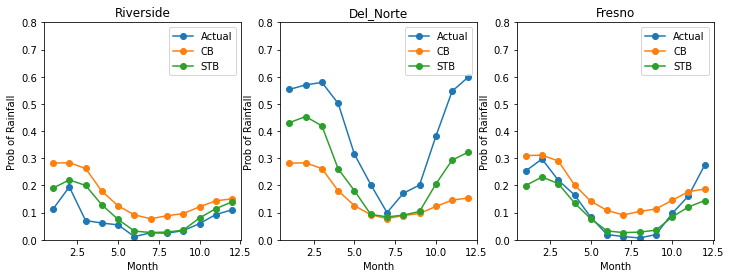

In [57]:
counties_to_examine = ['Riverside','Del_Norte','Fresno']
plt.figure(figsize=(12,4))
for i,county_name in enumerate(counties_to_examine):
    plt.subplot(1,3,i+1)
    plt.title(county_name)
    compare_models_to_actual([cb1, stboost_CA_2], county_name, mean_by_mc_full, model_names=['CB','STB'])

From the above, we can see that Catboost does not vary the prediction much among the different counties.  Without knowing, and exploiting, the geography, the county information is not very useful.

Meanwhile, StructureBoost is able to make different predictions for the different counties in a "smart" way

## Unseen Categorical Values
Another advantage of exploiting categorical structure is that you can make better predictions on categorical values that are completely unseen in the training data.  In the following, we will omit data from a few counties from our training set, and then see how well the different models do in predicting the precipitation patterns in the absence of the specific data.

In [58]:
X_trva, X_test, y_trva, y_test = train_test_split(X,y, test_size = 100000, random_state=42)
X_train_big, X_valid, y_train_big, y_valid = train_test_split(X_trva, y_trva, 
                                                              test_size = 10000, random_state=42)


In [59]:
num_train_pts = 2500
X_train = X_train_big.iloc[:num_train_pts,:]
y_train = y_train_big[:num_train_pts]

In [60]:
# Create a list of counties to leave out, and remove those data points from both training and validation sets
counties_to_omit = ['Humboldt', 'Sierra', 'Riverside']
X_train_omit = X_train[np.logical_not(X_train.county.isin(counties_to_omit))]
y_train_omit = y_train[np.logical_not(X_train.county.isin(counties_to_omit))]

X_valid_omit = X_valid[np.logical_not(X_valid.county.isin(counties_to_omit))]
y_valid_omit = y_valid[np.logical_not(X_valid.county.isin(counties_to_omit))]


X_test_omit = X_test[X_test.county.isin(counties_to_omit)]
y_test_omit = y_test[X_test.county.isin(counties_to_omit)]

In [61]:
# Define and fit the StructureBoost model
stboost_CA_omit = stb.StructureBoost(num_trees = 1500, learning_rate=.02, feature_configs=feature_configs_2, 
                                 max_depth=2, mode='classification')

stboost_CA_omit.fit(X_train_omit, y_train_omit, eval_set = ((X_valid_omit, y_valid_omit)), early_stop_past_steps=2, eval_freq=20)

i=0, eval_set_loss = 0.47599358665988967
i=20, eval_set_loss = 0.4482276698801378
i=40, eval_set_loss = 0.4335864346525054
i=60, eval_set_loss = 0.4256103219973885
i=80, eval_set_loss = 0.42089485321632564
i=100, eval_set_loss = 0.41708934210904786
i=120, eval_set_loss = 0.4149964053574228
i=140, eval_set_loss = 0.41382036239540637
i=160, eval_set_loss = 0.4131319358442676
i=180, eval_set_loss = 0.4127071392353261
i=200, eval_set_loss = 0.41228089682094826
i=220, eval_set_loss = 0.4121983786410953
i=240, eval_set_loss = 0.41228095309897794
Stopping early: curr_loss of 0.41228095309897794
                                        exceeds compare_loss of 0.41228089682094826


In [62]:
# Predict the probabilities
pred_probs_omit = stboost_CA_omit.predict(X_test_omit)

In [63]:
# Define and fit the StructureBoost model on all data
stboost_CA = stb.StructureBoost(num_trees = 1500, learning_rate=.02, feature_configs=feature_configs_2, 
                                 max_depth=2, mode='classification')

stboost_CA.fit(X_train, y_train, eval_set = ((X_valid, y_valid)), early_stop_past_steps=2, eval_freq=20)

i=0, eval_set_loss = 0.479944879490961
i=20, eval_set_loss = 0.452322445037275
i=40, eval_set_loss = 0.43759050106952246
i=60, eval_set_loss = 0.42938469083384534
i=80, eval_set_loss = 0.4239143122926165
i=100, eval_set_loss = 0.420485308019606
i=120, eval_set_loss = 0.4184892476576941
i=140, eval_set_loss = 0.41713106859058324
i=160, eval_set_loss = 0.416168486746046
i=180, eval_set_loss = 0.4158115151187254
i=200, eval_set_loss = 0.4153588084525911
i=220, eval_set_loss = 0.4151705395998157
i=240, eval_set_loss = 0.41504375115735404
i=260, eval_set_loss = 0.4148326813168532
i=280, eval_set_loss = 0.41481858556937806
i=300, eval_set_loss = 0.41507178722156796
Stopping early: curr_loss of 0.41507178722156796
                                        exceeds compare_loss of 0.4148326813168532


In [64]:
# Predict the probabilities
pred_probs_stb = stboost_CA.predict(X_test_omit)

In [65]:
# Fit a comparable CatBoost model
cat_features = ['county']
cb_model_omit = cb.CatBoostClassifier(iterations=1500, early_stopping_rounds=40, max_depth=2,
                             learning_rate=.02, cat_features=cat_features)

cb_model_omit.fit(X_train_omit, y_train_omit, cat_features, eval_set=(X_valid_omit, y_valid_omit), verbose=20)

0:	learn: 0.6828144	test: 0.6828379	best: 0.6828379 (0)	total: 2.32ms	remaining: 3.48s
20:	learn: 0.5352189	test: 0.5337606	best: 0.5337606 (20)	total: 38.2ms	remaining: 2.69s
40:	learn: 0.4779125	test: 0.4755360	best: 0.4755360 (40)	total: 71.9ms	remaining: 2.56s
60:	learn: 0.4534252	test: 0.4505807	best: 0.4505807 (60)	total: 108ms	remaining: 2.55s
80:	learn: 0.4429585	test: 0.4399431	best: 0.4399431 (80)	total: 152ms	remaining: 2.67s
100:	learn: 0.4362926	test: 0.4332544	best: 0.4332544 (100)	total: 194ms	remaining: 2.68s
120:	learn: 0.4329672	test: 0.4299444	best: 0.4299444 (120)	total: 227ms	remaining: 2.59s
140:	learn: 0.4303397	test: 0.4273043	best: 0.4273043 (140)	total: 256ms	remaining: 2.47s
160:	learn: 0.4290627	test: 0.4261622	best: 0.4261622 (160)	total: 285ms	remaining: 2.37s
180:	learn: 0.4270351	test: 0.4243268	best: 0.4243268 (180)	total: 312ms	remaining: 2.27s
200:	learn: 0.4257364	test: 0.4234277	best: 0.4234277 (200)	total: 340ms	remaining: 2.2s
220:	learn: 0.424699

In [66]:
# Make predictions
pred_probs_cb_omit = cb_model_omit.predict_proba(X_test_omit)[:,1]

In [67]:
# Calculate the log_loss and AUROC on the test set
log_loss(y_test_omit, pred_probs_omit), roc_auc_score(y_test_omit, pred_probs_omit)

(0.4418341147351942, 0.7623013304040452)

In [68]:
# Compare to the previous StructureBoost that saw all counties
log_loss(y_test_omit, pred_probs_stb), roc_auc_score(y_test_omit, pred_probs_stb)

(0.4321634412294584, 0.7807368616789571)

In [69]:
# Evaluate results
log_loss(y_test_omit, pred_probs_cb_omit), roc_auc_score(y_test_omit, pred_probs_cb_omit)

(0.518033056292683, 0.6851004044414524)

### Compare predictions on the unseen counties

In [70]:
counties_to_omit

['Humboldt', 'Sierra', 'Riverside']

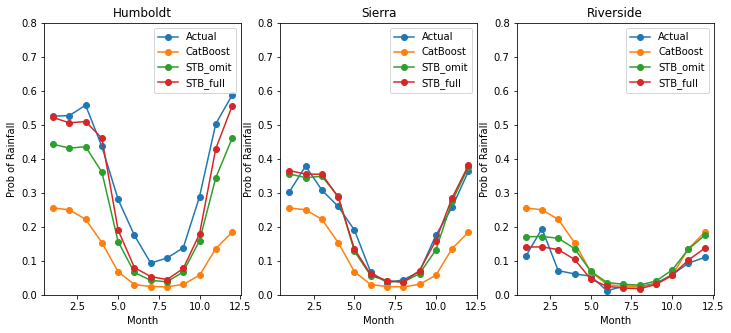

In [71]:
mod_names = ['CatBoost','STB_omit','STB_full']
plt.figure(figsize=(12,5))
for i in range(len(counties_to_omit)):
    plt.subplot(1,3,i+1)
    compare_models_to_actual([cb_model_omit, stboost_CA_omit, stboost_CA], counties_to_omit[i],
                             mean_by_mc_full, model_names=mod_names)
    plt.title(counties_to_omit[i])


Since CatBoost has no knowledge of the geographical structure of the counties, it makes the same prediction for all 3 unseen counties.  StructureBoost is able to appropriately average over the neighboring counties to yield better predictions in the absence of direct data.  Furthermore, StructureBoost does almost as well with or without the unseen counties



# Wrap-up

- ### Check out / Subscribe to my YouTube channel: https://www.youtube.com/numeristical
- ### Please rate this talk on the ODSC app!
- ### If you find the structureboost package useful, please give it a star on Github!
- ### Questions or problems with StructureBoost - email me: brian@numeristical.com
- ### Make an account at www.numeristical.com to be added to Slack / Discord
- ### Thanks!

## Repeat multiple trials to show results aren't noise
In case you think the above results are just noise, let's run multiple trials and compare.

In [72]:
num_train_pts = 1000
num_trials = 5
stb_def_loss_vec = np.zeros(num_trials)
stb_1_loss_vec = np.zeros(num_trials)
stb_2_loss_vec = np.zeros(num_trials)
cb1_loss_vec = np.zeros(num_trials)
cb2_loss_vec = np.zeros(num_trials)
ap1_loss_vec = np.zeros(num_trials)
ap2_loss_vec = np.zeros(num_trials)
stb_def_AUC_vec = np.zeros(num_trials)
stb_1_AUC_vec = np.zeros(num_trials)
stb_2_AUC_vec = np.zeros(num_trials)
cb1_AUC_vec = np.zeros(num_trials)
cb2_AUC_vec = np.zeros(num_trials)
ap1_AUC_vec = np.zeros(num_trials)
ap2_AUC_vec = np.zeros(num_trials)
for i in range(num_trials):
    print('Trial {} \n\n'.format(i))
    X_trva, X_test, y_trva, y_test = train_test_split(X,y, test_size = 100000, random_state=i)
    X_train_big, X_valid, y_train_big, y_valid = train_test_split(X_trva, y_trva, 
                                                                  test_size = 10000, random_state=i)
    X_train = X_train_big.iloc[:num_train_pts,:]
    y_train = y_train_big[:num_train_pts]
    
    # Get the "actual" probabilities and associated losses
    ap1 = pd.merge(X_test, mean_by_mc_full, on=['month','county'], how='left')['prob_of_rain']
    ap1_loss_vec[i] = log_loss(y_test, ap1)
    ap1_AUC_vec[i] = roc_auc_score(y_test, ap1)
    
    df_test = X_test.copy()
    df_test['rained'] = y_test
    mean_by_mc_test = df_test.groupby(['month','county'])['rained'].agg(['mean','count']).reset_index()
    mean_by_mc_test.columns = ['month', 'county', 'prob_of_rain', 'num_obs']
    ap2 = pd.merge(X_test, mean_by_mc_test, on=['month','county'], how='left')['prob_of_rain']
    ap2_loss_vec[i] = log_loss(y_test, ap2)
    ap2_AUC_vec[i] = roc_auc_score(y_test, ap2)

    stboost_CA_def = stb.StructureBoost(num_trees = 2000,
                                        learning_rate=.02,
                                        feature_configs=feature_configs_default, 
                                        max_depth=2,
                                        mode='classification',
                                        random_seed=i)
    stboost_CA_def.fit(X_train, y_train, 
                       eval_set = ((X_valid, y_valid)), 
                       early_stop_past_steps=1, 
                       eval_freq=20)

    pred_probs_def = stboost_CA_def.predict(X_test)
    stb_def_loss_vec[i] = log_loss(y_test, pred_probs_def)
    stb_def_AUC_vec[i] = roc_auc_score(y_test, pred_probs_def)

    stboost_CA_1 = stb.StructureBoost(num_trees = 2000,
                                      learning_rate=.02,
                                      feature_configs=feature_configs_1, 
                                      max_depth=2,
                                      mode='classification',
                                      random_seed=i)
    stboost_CA_1.fit(X_train, y_train, 
                       eval_set = ((X_valid, y_valid)), 
                       early_stop_past_steps=1, 
                       eval_freq=20)
    pred_probs_1 = stboost_CA_1.predict(X_test)
    stb_1_loss_vec[i] = log_loss(y_test, pred_probs_1)
    stb_1_AUC_vec[i] = roc_auc_score(y_test, pred_probs_1)
        

    stboost_CA_2 = stb.StructureBoost(num_trees = 2000,
                                      learning_rate=.02,
                                      feature_configs=feature_configs_2, 
                                      max_depth=2,
                                      mode='classification',
                                      random_seed=i)
    stboost_CA_2.fit(X_train, y_train, 
                       eval_set = ((X_valid, y_valid)), 
                       early_stop_past_steps=1, 
                       eval_freq=20)
    pred_probs_2 = stboost_CA_2.predict(X_test)
    stb_2_loss_vec[i] = log_loss(y_test, pred_probs_2)
    stb_2_AUC_vec[i] = roc_auc_score(y_test, pred_probs_2)

    
    cat_features_1 = ['county']
    cb1 = cb.CatBoostClassifier(iterations=2000, early_stopping_rounds=20,
                                max_depth=2,learning_rate=.02,
                                cat_features=cat_features_1, random_seed=i)
    cb1.fit(X_train, y_train, cat_features_1, eval_set=(X_valid, y_valid), verbose=25)
    pred_probs_cb1 = cb1.predict_proba(X_test)
    cb1_loss_vec = log_loss(y_test, pred_probs_cb1)
    cb1_AUC_vec = roc_auc_score(y_test, pred_probs_cb1[:,1])
    
    
    cat_features_2 = ['county', 'month']
    cb2 = cb.CatBoostClassifier(iterations=2000, early_stopping_rounds=20,
                                max_depth=2,learning_rate=.02,
                                cat_features=cat_features_2, random_seed=i)

    cb2.fit(X_train, y_train, cat_features_2, eval_set=(X_valid, y_valid), verbose=25)
    pred_probs_cb2 = cb2.predict_proba(X_test)
    cb2_loss_vec[i] = log_loss(y_test, pred_probs_cb2)
    cb2_AUC_vec[i] = roc_auc_score(y_test, pred_probs_cb2[:,1])
    

Trial 0 


i=0, eval_set_loss = 0.46881167156787507
i=20, eval_set_loss = 0.4487392603301738
i=40, eval_set_loss = 0.43809693508532216
i=60, eval_set_loss = 0.4313565054663136
i=80, eval_set_loss = 0.4288525943766475
i=100, eval_set_loss = 0.42558596297798995
i=120, eval_set_loss = 0.42361155032721637
i=140, eval_set_loss = 0.4226182355643541
i=160, eval_set_loss = 0.42172178541546435
i=180, eval_set_loss = 0.421079240211063
i=200, eval_set_loss = 0.4204837868593827
i=220, eval_set_loss = 0.4197209456610693
i=240, eval_set_loss = 0.4196868081258639
i=260, eval_set_loss = 0.4190754486280977
i=280, eval_set_loss = 0.41867505621089784
i=300, eval_set_loss = 0.41844352087637987
i=320, eval_set_loss = 0.4188832594198159
Stopping early: curr_loss of 0.4188832594198159
                                        exceeds compare_loss of 0.41844352087637987
i=0, eval_set_loss = 0.46881167156787507
i=20, eval_set_loss = 0.44695462688762017
i=40, eval_set_loss = 0.43400167125986844
i=60, eval_set_los

### Summary of results (multiple trials)

In [73]:
print('Average log_loss Scores:')
print('StructureBoost w County+Month Structure:     avg_loss = {}'.format(np.round(np.mean(stb_2_loss_vec),5)))
print('StructureBoost w County Structure:           avg_loss = {}'.format(np.round(np.mean(stb_1_loss_vec),5)))
print('StructureBoost (w no Structure):             avg_loss = {}'.format(np.round(np.mean(stb_def_loss_vec), 5)))
print('CatBoost:  (County categorical)              avg_loss = {}'.format(np.round(np.mean(cb1_loss_vec),5)))
print('CatBoost:  (County, Month categorical)       avg_loss = {}'.format(np.round(np.mean(cb2_loss_vec),5)))
print('"Actual":                                    avg_loss = {}'.format(np.round(np.mean(ap1_loss_vec),5)))
print('"Cheating":                                  avg_loss = {}'.format(np.round(np.mean(ap2_loss_vec),5)))
print('\nAverage ROC AUC Scores:')
print('StructureBoost w County+Month Structure:     avg_auc = {}'.format(np.round(np.mean(stb_2_AUC_vec),5)))
print('StructureBoost w County Structure:           avg_auc = {}'.format(np.round(np.mean(stb_1_AUC_vec),5)))
print('StructureBoost (w no Structure):             avg_auc = {}'.format(np.round(np.mean(stb_def_AUC_vec), 5)))
print('CatBoost:  (County categorical)              avg_auc = {}'.format(np.round(np.mean(cb1_AUC_vec),5)))
print('CatBoost:  (County, Month categorical)       avg_auc = {}'.format(np.round(np.mean(cb2_AUC_vec),5)))
print('"Actual":                                    avg_auc = {}'.format(np.round(np.mean(ap1_AUC_vec),5)))
print('"Cheating":                                  avg_auc = {}'.format(np.round(np.mean(ap2_AUC_vec),5)))


Average log_loss Scores:
StructureBoost w County+Month Structure:     avg_loss = 0.40919
StructureBoost w County Structure:           avg_loss = 0.41291
StructureBoost (w no Structure):             avg_loss = 0.41855
CatBoost:  (County categorical)              avg_loss = 0.41775
CatBoost:  (County, Month categorical)       avg_loss = 0.41934
"Actual":                                    avg_loss = 0.39643
"Cheating":                                  avg_loss = 0.39365

Average ROC AUC Scores:
StructureBoost w County+Month Structure:     avg_auc = 0.75168
StructureBoost w County Structure:           avg_auc = 0.74789
StructureBoost (w no Structure):             avg_auc = 0.7333
CatBoost:  (County categorical)              avg_auc = 0.72871
CatBoost:  (County, Month categorical)       avg_auc = 0.7278
"Actual":                                    avg_auc = 0.76927
"Cheating":                                  avg_auc = 0.77374


In [74]:
log_loss_diff_vec = cb1_loss_vec-stb_2_loss_vec
log_loss_diff_vec

array([0.00921028, 0.00675477, 0.01030572, 0.0054796 , 0.01104851])

In [75]:
## mean and std deviation of log_loss difference
## between StructureBoost and CatBoost
np.mean(log_loss_diff_vec), np.std(log_loss_diff_vec)

(0.008559775324781837, 0.0021171126991326793)

In [76]:
# min and max of discrepancy
np.min(log_loss_diff_vec), np.max(log_loss_diff_vec)

(0.005479596107790363, 0.011048510160789282)

In [77]:
roc_auc_score(y_test,pred_probs_2), roc_auc_score(y_test,pred_probs_cb1[:,1])

(0.7517772480970504, 0.7287116602746111)

In [78]:
auc_diff_vec = stb_2_AUC_vec - cb1_AUC_vec
auc_diff_vec

array([0.02788529, 0.02098127, 0.02721093, 0.01570482, 0.02306559])

In [79]:
## mean and std deviation of AUC difference
## between StructureBoost and CatBoost
np.mean(auc_diff_vec), np.std(auc_diff_vec)

(0.022969581581848364, 0.00444730384952902)

In [80]:
# min and max of discrepancy
np.min(auc_diff_vec), np.max(auc_diff_vec)

(0.015704824791995087, 0.027885290297866572)